<a href="https://colab.research.google.com/github/fedhere/FDSfE_FBianco/blob/main/codedemos/PhillyCitiBikes_partiallyFilledNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Bikeshare Data from rideindego.com

while the data is open and accessible it is stored in poorly maintained. It is stored in individual files for each quarter from 2016 through 2022 - zipped csv files (but occasionally additional files are indcluded in the compressed zip) and the naming scheme for the files is not systematic, which is very annoying, and also really common.
I use the ```urllib3``` library to download the page with all the links to the data files and ```BeautifulSoup`` to read the html page and extract the links. 

Additionally I use ```os``` and ```glob``` to downlead, and to find and open the data files after I downloaded them.

Later I use ```pandas``` to read the csv files in

For the geospatial analysis I will use
- ```shapely``` to create points and lines
- ```geopandas``` to plot
- ```folium``` for working with leaflet maps

Finally I will import the colormap tools from matplotlib to map colors to variables in my maps

In [11]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 15.3 MB/s 
     |████████████████████████████████| 6.3 MB 43.1 MB/s 
     |████████████████████████████████| 16.7 MB 51.8 MB/s 


In [12]:
# interacting with hosting site
import urllib3
from bs4 import BeautifulSoup

# getting and reading files
import os
import glob
import pandas as pd

# geospatial analysis 
from shapely.geometry import Point, LineString
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster

# I need to set colormaps to be mapped to variables

from matplotlib import cm






# getting the data


## get the links

In [13]:
http = urllib3.PoolManager()
c = http.request('GET', url="https://www.rideindego.com/about/data/")
soup = BeautifulSoup(c.data.decode('utf-8'))


/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [ ]:
#the webpage with the links
soup.prettify()

In [ ]:
#the list of links
linklist = [link.get('href') for link in soup.find_all('a') 
              if "upload" in link.get('href')]
linklist              

## download and read the links

In [16]:
#downloading each link
for url in linklist:
  os.system("wget " + url)

In [ ]:
#the list of files locally
glob.glob("*rips*")

In [ ]:
# read in the csv file - each file is read in into a "dictionary" - the data can then be retrieved by year and quarder:
# e.g. pds[2016][Q1] retrieves the data from 2016 January 1st through 2016 March 31st
pds = {} # prepare the container
for y in range(2015, 2023): #loop over all years
  print(y)
  pds[y] = {}
  _ = [url for url in glob.glob("*rips*") if ("%d"%y in url)]
  for q in range(1, 5):
    print("\t", q)
    try:
      pds[y][q] = pd.read_csv([url for url in _ 
                             if ("Q%d"%q in url) or ("q%d"%q in url)][0])
    except ValueError:
      os.system("unzip " + [url for url in _ 
                             if ("Q%d"%q in url) or ("q%d"%q in url)][0])
      try:
        pds[y][q] = pd.read_csv([url for url in glob.glob("*rips*csv") if (("%d"%y in url) and 
                                (("Q%d"%q in url) or ("q%d"%q in url)))][0])
      except IndexError:
        print("\t\tno data for this quarter")
    except IndexError:
      print("\t\tno data for this quarter")

# explore the data

In [ ]:
#get the info for each year and each quarter
for y in pds.keys(): #years look
  for q in pds[y].keys(): #quarter loop
    print(pds[y][q].info())

In [ ]:
#get the number of rows and columns for each year and quarter
for y in pds.keys(): #year loop
  for q in pds[y].keys(): #quarter loop
    print(pds[y][q].shape)

In [ ]:
# an example of a file # 2022-July thorugh 2022-September
pds[2021][3].head()

In [ ]:
pds[2021][3].describe()


# data preprocessing

In [28]:
#convert date column to a datetime object
pds[2021][3]["start_date"] = pd.to_datetime(pds[2021][3]["start_time"]).dt.date

In [29]:
# create a point from the latitude-longitude values of the start of the trip
pds[2021][3]["startlonlat"] = pds[2021][3][["start_lon", "start_lat"]].apply(lambda x: 
                          Point(x['start_lon'], x['start_lat']), axis=1)


/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [30]:
# create a point from the latitude-longitude values of the end of the trip
pds[2021][3]["endlonlat"] = pds[2021][3][["end_lon", "end_lat"]].apply(lambda x: 
                          Point(x['end_lon'], x['end_lat']), axis=1)


In [31]:
# create a line between the start and end positions... not so easy!
pds[2021][3][["startlonlat", "endlonlat"]].apply(lambda x:
              LineString([x["startlonlat"], x["endlonlat"]]), axis=1)

IndexError: ignored

In [33]:
def makeline(x, y):
  try: 
    _ = LineString([x, y])
  except IndexError:
    _ =  LineString([(0,0), (0,0)])
  return _

pds[2021][3]["trip"] = pds[2021][3][["startlonlat", "endlonlat"]].apply(lambda x: 
                          makeline(x["startlonlat"], x["endlonlat"]), axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [34]:
#get only the 1-way trips
tripdf = pds[2021][3]
tripdf = tripdf[tripdf["trip_route_category"] == "One Way"]

In [35]:
#remove the trips with missing coordinates
tripdf = tripdf[~tripdf["start_lat"].isna()]
tripdf = tripdf[~tripdf["end_lat"].isna()]


In [36]:
tripdf.shape

(269796, 19)

# mapping and geospatial analysis

#simple plots with geopandas: I can plot the bike stations 
trajectories

In [37]:
#convert to geodataframe
gpds = pds[2021][3]
gpds = gpd.GeoDataFrame(gpds)
gpds["geometry"] = gpds["startlonlat"] # associate the trip trajectories to the geometry in the geodataframe

In [ ]:
gpds.plot()

I can plot the trip trajectories

In [39]:
#convert to geodataframe
gpds = pds[2021][3]
gpds = gpd.GeoDataFrame(gpds)
gpds["geometry"] = gpds["trip"] # associate the trip trajectories to the geometry in the geodataframe

## plot the zipcodes of Philly

In [ ]:
# get the zipcode dataframe
zips = gpd.GeoDataFrame.from_file("https://opendata.arcgis.com/api/v3/datasets/b54ec5210cee41c3a884c9086f7af1be_0/downloads/data?format=shp&spatialRefId=4326")
zips.plot(ec = "k", fc="none");

In [ ]:
# what is the coordinate system for the geo data? 
zips.crs

In [42]:
#set the same coordinate system for the bike trajectories
gpds.crs = zips.crs

In [ ]:
#plot stations over the trip trajectories
ax = zips.plot(ec = "k", fc="none")
xlim = ax.get_xlim()
ylim = ax.get_ylim()
gpds["geometry"] = gpds["startlonlat"] # associate the trip trajectories to the geometry in the geodataframe
gpds.plot(ax = ax, alpha=0.1)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel("longitude")
ax.set_ylabel("latitude")

Text(30.25, 0.5, 'latitude')

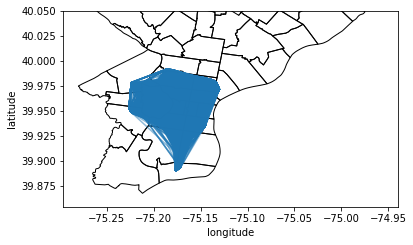

In [73]:
#plot trips over the trip trajectories (start with a subset cuase this it time consuming!)
ax = zips.plot(ec = "k", fc="none")
xlim = ax.get_xlim()
ylim = ax.get_ylim()
gpds["geometry"] = gpds["trip"] # associate the trip trajectories to the geometry in the geodataframegpds[:100].plot(ax = ax, alpha=0.5)
gpds.plot(ax = ax, alpha=0.5)
ax.set_xlim(xlim)
ax.set_ylim(ylim[0], 40.05);
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")

In [ ]:
#plot trips over the trip trajectories
ax = zips.plot(ec = "k", fc="none")
xlim = ax.get_xlim()
ylim = ax.get_ylim()
gpds.plot(ax = ax, alpha=0.1)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel("longitude")
ax.set_ylabel("latitude")

In [ ]:
#measure trip length
gpds["triplen"] = gpds.geometry.length
gpds.describe()

In [45]:
#normalize trip lenght
#max of len is .090212
c = cm.viridis(gpds["triplen"] / (0.090212))

In [ ]:
#map color of the trip to trip length
ax = zips.plot(ec = "k", fc="none")
xlim = ax.get_xlim()
ylim = ax.get_ylim()
gpds.plot(ax = ax, alpha=0.005, 
                color = cm.viridis(gpds["triplen"] / (0.090212)))
ax.set_xlim(-75.25, -75.1)
ax.set_ylim(39.880, 40.01);

ax.set_xlabel("longitude")
ax.set_ylabel("latitude")

In [ ]:
#Define coordinates of where we want to center our map
phl = [ 39.952583,  -75.165222]

#Create the map
my_map = folium.Map(location = phl, zoom_start = 12)

#Display the map
my_map

In [ ]:
stations = gpds.groupby("start_station").first()
stations

In [ ]:
stations.loc[3255, "startlonlat"].x

In [53]:
stations = stations.dropna()

In [ ]:
#Create the map

my_map = folium.Map(location = phl, zoom_start = 12)



for i in stations.index:
  folium.RegularPolygonMarker((stations.loc[i, "start_lat"], 
                               stations.loc[i, "start_lon"]), 
                              popup = "%d"%i, 
                              color = '#00ff40',
                              number_of_sides = 3, 
                              radius = 3).add_to(my_map)

#Display the map
my_map


In [ ]:
ax = zips.plot(ec = "k", fc="none")
xlim = ax.get_xlim()
ylim = ax.get_ylim()
gpds[:10000].plot(ax = ax, alpha=0.05, 
                color = cm.viridis(gpds["triplen"] / (0.090212)))
ax.set_xlim(-75.25, -75.1)
ax.set_ylim(39.880, 40.01);

ax.set_xlabel("longitude")
ax.set_ylabel("latitude");

In [ ]:
ax = zips.plot(ec = "k", fc="none")
xlim = ax.get_xlim()
ylim = ax.get_ylim()
gpds[:100000].plot(ax = ax, alpha=0.005, 
                color = cm.viridis(gpds["triplen"] / (0.090212)))
ax.set_xlim(-75.25, -75.1)
ax.set_ylim(39.880, 40.01);

ax.set_xlabel("longitude")
ax.set_ylabel("latitude");

In [ ]:
import matplotlib


#Create the map
my_map = folium.Map(location = phl, zoom_start = 12)



for i in stations.index:
  folium.RegularPolygonMarker((stations.loc[i, "start_lat"], 
                               stations.loc[i, "start_lon"]), 
                              popup = "%d"%i, 
                              fill_color = "0000ff",
                              number_of_sides = 4, 
                              radius = stations.loc[i, "triplen"] / (0.090212) * 3).add_to(my_map)

#Display the map
my_map


In [ ]:


#Create the map
my_map = folium.Map(location = phl, zoom_start = 12)
folium.TileLayer('cartodbpositron').add_to(my_map)



for i in stations.index:
  folium.RegularPolygonMarker((stations.loc[i, "start_lat"], 
                               stations.loc[i, "start_lon"]), 
                              popup = "%d"%i, 
                              fill_color = "0000ff",
                              number_of_sides = 4, 
                              radius = stations.loc[i, "triplen"] / (0.090212) * 3).add_to(my_map)

#Display the map
my_map


In [ ]:
origins = gpds.groupby("start_station").count()[["trip_id"]].rename({
    "trip_id":"ntrips"}, axis=1)
origins

In [62]:
stations = stations.merge(origins, left_index=True, right_index=True)

In [ ]:
stations["ntrips"].max()

In [ ]:
#Create the map
my_map = folium.Map(location = phl, zoom_start = 12.2)
folium.TileLayer('cartodbpositron').add_to(my_map)

for i in stations.index:
  folium.RegularPolygonMarker((stations.loc[i, "start_lat"], 
                               stations.loc[i, "start_lon"]), 
                              popup = "%d"%i, 
                              color = 
                              matplotlib.colors.rgb2hex(
                                  cm.viridis(stations.loc[i, "ntrips"] / 4750 * 3)),
                              number_of_sides = 10, 
                              radius = stations.loc[i, "triplen"] / .090212 * 3
                              #stations.loc[i, "ntrips"] / 4750 * 3
                              ).add_to(my_map)

#Display the map
print("Citibike stations by popularity (size) and trip length (color)")
my_map

In [ ]:
bikes = gpds.groupby("bike_id").count()
bikes["trip_id"].max()

In [67]:
most_pop_bike = bikes[bikes["trip_id"] == 294].index[0]

In [ ]:
ax = zips.plot(ec = "k", fc="none")
xlim = ax.get_xlim()
ylim = ax.get_ylim()
gpds[gpds.bike_id == most_pop_bike].plot(ax = ax, alpha=0.5, 
                color = cm.viridis(gpds["triplen"] / (0.090212)))
ax.set_xlim(-75.25, -75.1)
ax.set_ylim(39.880, 40.01);

In [ ]:
gpds[gpds.bike_id == most_pop_bike]

In [ ]:
#Create the map
my_map = folium.Map(location = phl, zoom_start = 12)

folium.TileLayer('cartodbpositron').add_to(my_map)


for i in stations.index:
  folium.PolyLine(((stations.loc[i, "start_lat"], 
                               stations.loc[i, "start_lon"]), 
                   (stations.loc[i, "end_lat"], 
                               stations.loc[i, "end_lon"])), 
                              popup = "%d"%i, 
                              opacity=0.5,
                              color = matplotlib.colors.rgb2hex(
                                  cm.viridis(stations.loc[i, "triplen"] / .090212)),
                              weight=1 ,
                              radius = stations.loc[i, "ntrips"] / 4750 * 3).add_to(my_map)

#Display the map
my_map
